# Quick tour
_________________________________________

<a target="_blank" href="https://colab.research.google.com/github/mithril-security/bastionlab/blob/v0.3.6/docs/docs/quick-tour/quick-tour.ipynb">
  <p align="center"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Why BastionLab?
________________________________________
Data owners often need or wish that remote data scientists would access their datasets - like a hospital might want to valorize their data to external parties, startups, labs, or receive help from external experts, for instance. 
The problem is that the most popular solution is to give access to a Jupyter Python notebook installed on the data owner infrastructure. 


This is dangerous, because it exposes the dataset to serious data leakages. Jupyter was not made for this task and exfiltrating data can easily be done.

That is why we have built BastionLab, a simple privacy framework to perform remote and secure Exploratory Data Analysis. It acts like an access control solution, for data owners to protect the privacy of their datasets, and stands as a guard, to enforce that only privacy-friendly operations are allowed on the data and anonymized outputs are shown to the data scientist.

The following plan illustrates the architecture of BastionLab and the workflow we implement:


![](https://github.com/mithril-security/bastionlab/raw/master/docs/assets/BastionLab_Workflow.png)

BastionLab's current main feature is to show *only* aggregated results to maintain privacy with a minimal sample size to ensure the anonymization of each individual. Differential Privacy will be integrated transparently in the future.

Technically, the framework uses polars (a Rust equivalent of pandas) lazy API to construct the queries locally. Once built, the queries are sent to the remote server of BastionLab and executed, if they pass the privacy policy rules defined by the data owner. BastionLab supports most data wrangling operations, like selects, groupbys, joins…

## Tutorial's introduction
__________________________________________________

In the following notebook tutorial, we will show you **how to install BastionLab** and **use a few basic functionalities**. 

We’ll use a mock example in which the data owner puts a Titanic passengers dataset at the disposal of the data scientist. By the end, the data scientist will be able to do **Exploratory Data Analysis remotely**, **under the privacy policy** constraints defined **by the data owner**.

You can run the folliwing line to download the dataset:

In [ ]:
!wget 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'

*Or you can get it from source with a free user account at https://www.kaggle.com/competitions/titanic/data)*

<br>

This notebook is divided into three parts:  
- Installation of BastionLab client and server
- The data owner's side
- The data scientist's side

>If you opened this Quick Tour in Collab, you can go ahead and skip the next step.

If you didn't, it's not too late! You can do it [here](https://colab.research.google.com/github/mithril-security/bastionlab/blob/v0.3.5/docs/docs/getting-started/quick-tour.ipynb) - it will let you run all the command lines and try out BastionLab without having to install anything on your machine. 

Else, you can refer to our [Installation tutorial](https://bastionlab.readthedocs.io/en/latest/docs/tutorials/installation/) to check you have the correct technical requirements. 

## Installing BastionLab client
_________________________________________

We provide a pip package for our client library that contains all the necessary to interact with the BastionLab server. 

It provides high level abstraction such as remote objects which mimic the behavior of plain local objects. These objects actually are references to remote resources and allow running remote computations seemlessly in a secure fashion.

In [ ]:
!pip install bastionlab

## Installing BastionLab server
____________________________________________________

For testing purposes, BastionLab server has been packaged as a pip wheel. In this tutorial, we will use this package to quickly set up a test server.

In [ ]:
!pip install bastionlab_server

*You may alternatively install BastionLab Server using our Docker image or from source. To do so, refer to our more detailed [Installation Tutorial](https://bastionlab.readthedocs.io/en/latest/docs/tutorials/installation/).*

### Running BastionLab server

The server exposes port `50056` for gRPC communication with clients and uses a default configuration (authentication, default settings).

>*Note* - You can go check out our [Authentication tutorial](https://bastionlab.readthedocs.io/en/latest/docs/tutorials/authentication/) to learn more about how it works, and see how to disable that option if, for example, you're deploying locally.

To run the server, we use the utility function provided by the `bastionlab_server` package.

In [4]:
import bastionlab_server

srv = bastionlab_server.start()

BastionLab server (version 0.3.5) already installed
Libtorch (version 1.12.1) already installed
TLS certificates already generated
Bastionlab server is now running on port 50056


[2023-01-03T17:02:48Z INFO  bastionlab] Authentication is disabled.
[2023-01-03T17:02:48Z INFO  bastionlab] Telemetry is disabled.
[2023-01-03T17:02:48Z INFO  bastionlab] BastionLab server listening on 0.0.0.0:50056.
[2023-01-03T17:02:48Z INFO  bastionlab] Server ready to take requests


## Data owner's side
_______________________________________

In this tutorial, we assume that the data owner has a private dataset they want to explore. As they don't have the expertise, they would like to hire a data scientist and give them restricted access to their private data.

> To keep this overview short and simple, we will use weak but reasonable guarantees. If you're interested in setting up stricter policies, you are encouraged to have a look at our [Privacy policy tutorial](https://github.com/mithril-security/bastionlab/blob/master/docs/docs/tutorials/policy.ipynb).

In this part, we'll see how to **upload a data frame** to the server and **set up a privacy policy**. It is key to know that BastionLab ensures that **the original dataset cannot be downloaded by the data scientist**.

### Upload the data frame to the BastionLab client

We first load the Titanic dataset in memory as a DataFrame object:

In [1]:
import polars as pl

df = pl.read_csv("titanic.csv")

We then open a connection to the server by providing its hostname:

In [2]:
from bastionlab import Connection

connection = Connection("localhost")

### Setting up the privacy policy

Using BastionLab client, we'll upload our data to the server in a secure and private way. To do so, we need to define a custom privacy policy that will require two parameters.

- A `safe_zone` which is a condition any request must meet to be considered privacy-preserving.
- An `unsafe_handling` which is the action taken in case a request violates the `safe_zone`.

For the purpose of this tutorial, we'll use the following:
- Any request that aggregates at least 10 rows of the original DataFrame is safe,
- We decide to log any offending request on the server side, so the Data Owner can see it.

To send the DataFrame with the privacy policy to the server, we'll use the `send_df()` method of the `polars` interface of the client. We'll pass it our custom policy and a list of columns to be sanitized (*meaning set to null*) if retrieved by the data scientist.

In [5]:
from bastionlab.polars.policy import Policy, Aggregation, Log

policy = Policy(safe_zone=Aggregation(min_agg_size=10), unsafe_handling=Log())
connection.client.polars.send_df(df, policy=policy, sanitized_columns=["Name"])

{"safe_zone":{"Aggregation":10},"unsafe_handling":"Log"}


[2023-01-03T17:02:52Z INFO  bastionlab_polars] Succesfully sent dataframe 3bc41715-e408-4b6a-b053-606c50019e5e to server


FetchableLazyFrame(identifier=3bc41715-e408-4b6a-b053-606c50019e5e)

The server returns a `FetchableLazyFrame` which is a reference to the remote DataFrame. It can be used as if it were locally available. We'll see how to use it in the data scientist's side section.

### Deleting a dataframe

The data owner can delete dataframes on the server, they are the only one with the right to perfom a deletion.

To show you how it works, let's send a dataframe and then delete it. We’ll use the `delete_df()` method and give it the RemoteDataFrame `identifier` argument.

We'll list the dataframes available on the server before and after the deletion  to test it.

In [ ]:
# We create a RemoteLazyFrame with our dataset
rdf = connection.client.polars.send_df(df, policy=policy, sanitized_columns=["Name"])

# We test it's been created
print(connection.client.polars.list_dfs())

# We delete the dataframe using the delete_df method
connection.client.polars.delete_df(rdf.identifier)

# We can't find it in the list now: it's been deleted!
print(connection.client.polars.list_dfs())

## Data scientist’s side
______________________________________________

In this part, we’ll show how the data scientist can **access the Data Owner’s dataset**, **run queries**, **fetch the results**, and **display them**.

### Access the data owner’s dataset 

The core object of BastionLab's polars API is the `RemoteLazyFrame` which is a reference to the DataFrame uploaded by the data owner, along with some metadata such as the names and types of the columns. 

`RemoteLazyFrame` usually works like a plain Polars `LazyFrame`. Almost all the functions available in the Python API of Polars can be used with `RemoteLazyFrame` to run computations on the server.

There are a few differences, however. One major distinction is that data must be downloaded *prior* to any local usage, such as printing or plotting. Because our API is inherently lazy, not all `RemoteLazyFrame` can be downloaded because it would not make sense to download a result that hasn't been computed yet on the server. Only `FetchableLazyFrame`, a subtype of `RemoteLazyFrame` can be downloaded with their specific `fetch()` method. 

Like in Polars' `LazyFrame`, the user must first call the `collect()` method to run the computation and get a `FetchableLazyFrame` as a result. In practice, this means that most calls to `collect()` with `polars` will be replaced by `collect().fetch()` with `bastionai.polars` 

At this stage, we do not know the unique identifier of the DataFrame uploaded by the data owner. So we'll start by asking the server to list all available DataFrames.

In [5]:
connection = Connection("localhost", 50056)

client = connection.client

all_rdfs = client.polars.list_dfs()

rdf = all_rdfs[0]

all_rdfs

[FetchableLazyFrame(identifier=613769d5-feb6-4735-a722-b3590732e62b)]

The server returns a list of `FetchableLazyFrame` that we can inspect. In our case, we can just take the first one as the data owner has only uploaded one DataFrame so far.

### Running queries

Now that we have a `RemoteLazyFrame` corresponding to the data owner’s DataFrame, it is time to run some queries on it.

To define these queries, we can directly use all the methods provided by Polars’ lazy API. 

>*Note* - Here, the adjective *lazy* means that no computation will be run unless explicitly needed. This allows the data scientist to build queries with a Pythonic approach from the RemoteLazyFrame. When an operation needs to be executed on the data, the query is serialized and sent to the server. 

The `collect()` method triggers the execution of all the recorded operations on the server.


In [6]:
rdf1 = rdf.head(5)
print(rdf1)

rdf2 = rdf1.collect()
print(rdf2)

RemoteLazyFrame
FetchableLazyFrame(identifier=a41457ef-3890-4127-9c7a-f6cbd79ce663)


In this example, the first line returns a new RemoteLazyFrame that records the head operation - nothing happens on the server. In the second line, however, the call to `collect()` sends a query to the server instructing it to do a head operation, and will run it right away.


What is key to understanding, is that **every call to `collect()` will create a new DataFrame** on the server side that contains the result.

On the client side, **`collect()` returns a new `FetchableLazyFrame`** that references the result on the server.

### Fetching results

At some point in your process, you will need to download the results to use them locally or to display them. 

This can be achieved with the `fetch()` method. It is defined on the `FetchableLazyFrame` class which extends the `RemoteLazyFrame` class. 

Recall that we’ve already seen the two ways of getting FetchableLazyFrames: by listing available DataFrames on the server, and by calling `collect()` on any RemoteLazyFrame. 

In practice, this means that `fetch()` can only be called on references to DataFrames, already available on the server, or after a call to `collect()`. As no computation has run before you call `collect()`, it wouldn’t actually make sense to `fetch()` the result because it does not yet exist! 


In [7]:
rdf.head(5).collect().fetch()

Reason: Cannot fetch a result DataFrame that does not aggregate at least 10 rows of DataFrame 613769d5-feb6-4735-a722-b3590732e62b.

This incident will be reported to the data owner.


PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
1,0,3,null,"""male""",22.0,1,0,"""A/5 21171""",7.25,null,"""S"""
2,1,1,null,"""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""C"""
3,1,3,null,"""female""",26.0,0,0,"""STON/O2. 31012...",7.925,null,"""S"""
4,1,1,null,"""female""",35.0,1,0,"""113803""",53.1,"""C123""","""S"""
5,0,3,null,"""male""",35.0,0,0,"""373450""",8.05,null,"""S"""


In addition, `fetch()` downloads the resulting DataFrame after performing some checks on how it was obtained and what the data owner authorizes in their policy. These checks allow BastionLab to uphold a decent level of privacy without too big an impact on your workflow.

Recall that the data owner has set the following policy:
- a `safe_zone` that accepts queries aggregating at least 10 original rows,
- the `Log` `unsafe_hanling` action which prints a message in the server logs in case of a violation of the `safe_zone`.

As printing the first rows of a DataFrame is not an aggregation, we are actually violating the safe zone which explains the printed warning message. The same message is also recorded in the logs of the server.

Also note that the `'Name'` column has been filled with `null` values as it was added to the `sanitized_columns` list by the data owner.


Let’s now try a more involved query: we compute the survival rates of the passengers on the Titanic based on their ticket class.

In [8]:
per_class_rates = (
    rdf.select([pl.col("Pclass"), pl.col("Survived")])
    .groupby(pl.col("Pclass"))
    .agg(pl.col("Survived").mean())
    .sort("Survived", reverse=True)
    .collect()
)
per_class_rates.fetch()

Pclass,Survived
i64,f64
1,0.62963
2,0.472826
3,0.242363


Once again, we must use:
- `collect()` to run the computation on the server,
- `fetch()` to retrieve the result locally. 

In this case, no message appears because the query involves an aggregation step.

### Saving Dataframes

You may want to save your dataframes so that you can continue operating on them at a later time. Saving your dataframes ensures that they will not be lost in the scenario of a server restart.

To save a dataframe you only need to call save() on the remote dataframe. The server will save that dataframe to a file and reload it when the server restarts.

In [9]:
per_class_rates.save()

Be aware that you must note down the identifier of the dataframe you saved so that you may identify it when you'd like to work on it again.

The identifier can be retrieved using the identifier property of the dataframe.

In [10]:
print(per_class_rates.identifier)

29a1637a-56bb-4478-933f-37b9840cc201


### Data visualization functions

The data scientist can also use plotting functions to visualize data while still upholding data privacy. It is important to note that, although plots are computed locally, the client only retrieves the necessary data, allowing the policy privacy garanties to stay intact.

#### Histograms

Histograms (and barplots) inherently aggregate data which makes them a good fit for private data exploration.
Instead of fetching the whole DataFrame, BastionLab client selects relevant rows, runs an aggregation query on the server and fetches the aggregated data.

In the following example, we plot the number of passengers who survived per age class. We set a bin size of 10 which means our age classes span 10 years.

Reason: Cannot fetch a result DataFrame that does not aggregate at least 10 rows of DataFrame 613769d5-feb6-4735-a722-b3590732e62b.

This incident will be reported to the data owner.


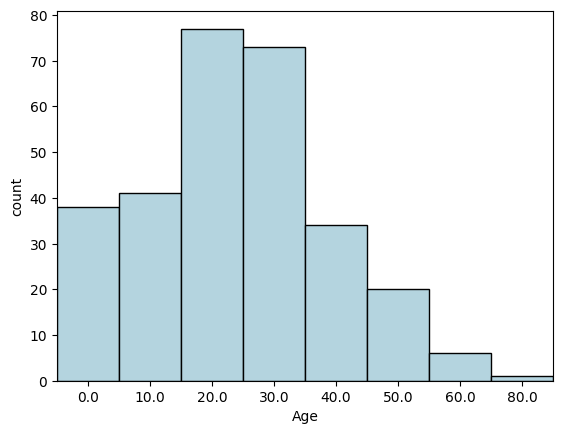

In [11]:
rdf.filter(pl.col("Survived") == 1).histplot(x="Age", bins=10)

We get a warning message because there are outliers in our data: people aged 70 or more are few. They form groups that are smaller than 10 in size and, so, they violate the data owner's policy.
In practice, outlier data are more vulnerable to deanonymization attacks because they make correlations easier to find. It is standard practice in privacy to remove outlier data to mitigate this risk.

One solution to make our example more-privacy preserving is to clip the age column to remove outliers prior to making the barplot.

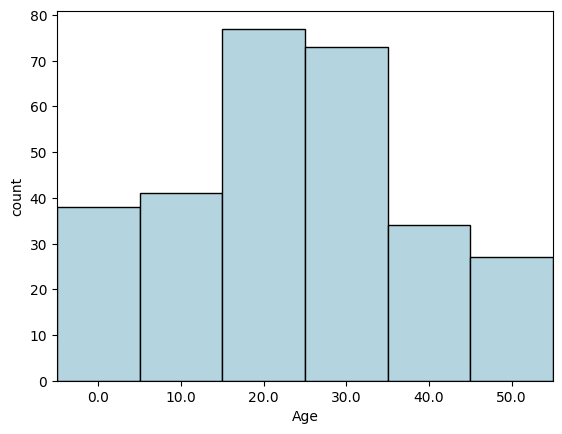

In [12]:
(
    rdf.select([pl.col("Survived"), pl.col("Age").clip(0, 50)])
    .filter(pl.col("Survived") == 1)
    .histplot(x="Age", bins=10)
)

In this case, outliers are counted in a new 50+ bin, and each bin aggregates at least 10 passengers. The query does not violate the safe zone anymore.

#### Curve and scatter plots

BastionLab also features other types of plots although these are less suited for privacy-preserving exploration.
They typically require fetching the whole DataFrame because they do not naturally involve an aggregation step like histograms do.

Bellow are two examples of the same relationship between age, fare and survival as a curve plot and as a scatter plot.

Reason: Cannot fetch a result DataFrame that does not aggregate at least 10 rows of DataFrame 613769d5-feb6-4735-a722-b3590732e62b.

This incident will be reported to the data owner.


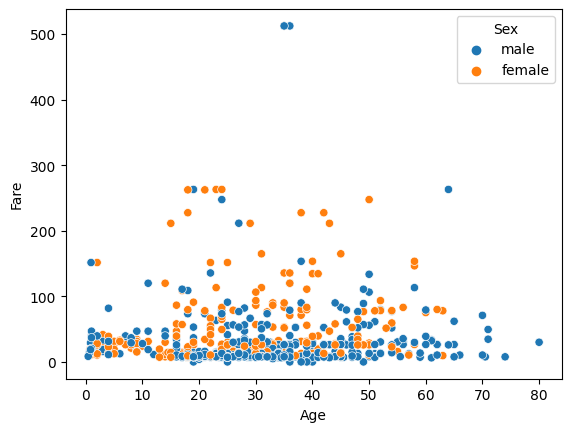

In [13]:
rdf.scatterplot(x="Age", y="Fare", hue="Sex")

Reason: Cannot fetch a result DataFrame that does not aggregate at least 10 rows of DataFrame 613769d5-feb6-4735-a722-b3590732e62b.

This incident will be reported to the data owner.


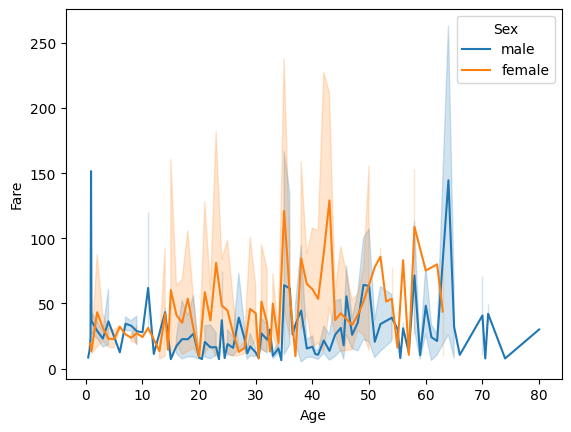

In [14]:
rdf.lineplot(x="Age", y="Fare", hue="Sex")

For more information on these functions and more complex examples, check out our data visualization tutorial [here](../tutorials/visualization.ipynb).

Let's now close the connection and shutdown the server.

In [15]:
connection.close()
bastionlab_server.stop(srv)